In [1]:
# Modules
#------------------------------------------------------------------------------

from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# from scipy.integrate import solve_ivp
# from scipy.special import gamma, airy

## Define first-principle reaction model

In [2]:
def true_rates(c, t):

    K1 = 0.8
    K2 = 0.1
    K3 = 0.01
    K4 = 0.01
    r0 = -K1 * c[0]
    r1 = K1 * c[0] - K2 * c[1] ** 2 - K3 * c[1]
    r2 = K2 * c[1] **2 - K4 * c[2]
    r3 = K3 * c[1]
    r4 = K4 * c[2]
    return [r0, r1, r2, r3, r4]



def pseudo_rates(c, t):
    
    K1 = 0.8 * 1.2
    K2 = 0.1 * 0.8  # erroneously measured parameter 
    K3 = 0.01
    K4 = 0.01
    r0 = -K1 * c[0]
    r1 = K1 * c[0] - K2 * c[1] - K3 * c[1]
    r2 = K2 * c[1] - K4 * c[2]
    r3 = K3 * c[1]
    r4 = K4 * c[2]
    return [r0, r1, r2, r3, r4]

## Generate concentration dataset

In [3]:
dt = 1                           # time step, delta t
tmin = 25
tmax = 45                             # max time, s
t = np.linspace(0, tmax, num=int(tmax/dt)+1) # time vector

components = ['A', 'B', 'C', 'D', 'E']
low_bound = [0, 0, 0, 0, 0]

# measurement errors

err_initial = 0.05
err_end = 0.2

# hyper-parameters

ode_tol = 1e-11
masking_val = -100
sample_size = 10000
timesteps = len(t)
features = len(components)

arr_initial_cc = []
arr_pseudo_profile = []
arr_true_profile = []
arr_true_end = []

# Temp = 0.5
# Pres = 0
# args = (Temp, Pres)


for i in range(sample_size):
    if np.random.random() < 0.8:
        high_bound = [1, 0.5, 0.5, 0.1, 0.1]
    else:
        high_bound = [1, 0.0, 0.0, 0.0, 0.0]
    
    initial_cc = np.random.uniform(low=low_bound, high=high_bound, size=len(components))
    initial_cc_with_error = [initial_cc[i] * np.random.normal(loc=1, scale=err_initial) for i in range(len(initial_cc))]
#     res_list = [test_list1[i] * test_list2[i] for i in range(len(test_list1))]

    # randomize end time between tmin and tmax
    
    tend = np.random.randint(tmin, tmax)
    t_span = t[:tend+1]
    
    pseudo_profile = odeint(pseudo_rates, initial_cc_with_error, t_span, rtol=ode_tol, atol=ode_tol)
    true_profile = odeint(true_rates, initial_cc, t_span, rtol=1e-10, atol=1e-10)
    true_end = true_profile[-1]
    
    # pad to match tmax
    
    pseudo_profile = np.pad(pseudo_profile, mode='constant', 
                            pad_width=[(0, tmax-tend), (0, 0)], 
                            constant_values=masking_val)
    true_profile = np.pad(true_profile, mode='constant', 
                            pad_width=[(0, tmax-tend), (0, 0)], 
                            constant_values=masking_val)
    
    arr_initial_cc.append(initial_cc)
    arr_true_end.append(true_end)
    arr_pseudo_profile.append(pseudo_profile)
    arr_true_profile.append(true_profile)

arr_initial_cc = np.reshape(arr_initial_cc, (sample_size, 1, features))
arr_true_end = np.reshape(arr_true_end, (sample_size, 1, features))
arr_pseudo_profile = np.reshape(arr_pseudo_profile, (sample_size, timesteps, features))
arr_true_profile = np.reshape(arr_true_profile, (sample_size, timesteps, features))

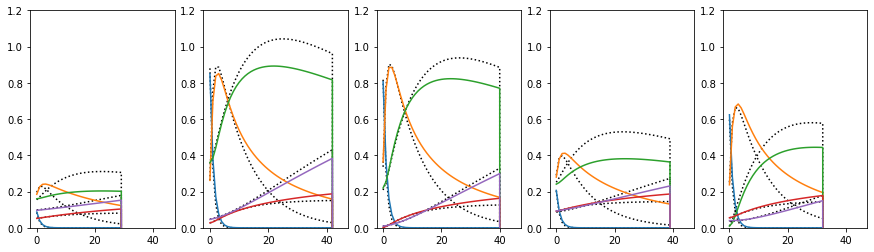

In [4]:
## Plot the first 5 reaction profiles

def example_plot(ax, plot_number, fontsize=12, hide_labels=False):
    ax.plot(t, arr_pseudo_profile[plot_number], color='black', linestyle='dotted')
    ax.plot(t, arr_true_profile[plot_number])
        
    ax.set_ylim([0, 1.2])

number_of_plots = sample_size if sample_size < 5 else 5

fig, axs = plt.subplots(1, number_of_plots, figsize=(15,4), constrained_layout=False)
for i in range(len(axs)):
    example_plot(axs[i], plot_number=i)

## log transformation

In [5]:
def ltu(arr, cc_cutoff=10**(-20)):
    ltu_arr = []
    
    arr_shape = np.shape(arr)
    flatten_arr = arr.flatten()
    
    for i in range(len(flatten_arr)):
        ele = flatten_arr[i]
        
        if ele > cc_cutoff:
            ltu_ele = np.log10(ele)
        elif ele == masking_val:
            ltu_ele = masking_val
        else:
            ltu_ele = np.log10(cc_cutoff) + ele - cc_cutoff
            
        ltu_arr.append(ltu_ele)
    
    ltu_arr = np.reshape(ltu_arr, arr_shape)
    return ltu_arr

def reverse_ltu(arr):
    reverse_ltu_arr = []
    
    arr_shape = np.shape(arr)
    flatten_arr = arr.flatten()
    
    for i in range(len(flatten_arr)):
        ele = flatten_arr[i]
        reverse_ltu_ele = 10**ele            
        reverse_ltu_arr.append(reverse_ltu_ele)
    
    reverse_ltu_arr = np.reshape(reverse_ltu_arr, arr_shape)
    return reverse_ltu_arr

In [6]:
## test log and reverse transformation

a = np.array([0.001, 0.002, 0, -100])
log_a = ltu(a)
b = reverse_ltu(log_a)

print(a)
print(log_a)
print(b)

[ 1.e-03  2.e-03  0.e+00 -1.e+02]
[  -3.        -2.69897  -20.      -100.     ]
[1.e-003 2.e-003 1.e-020 1.e-100]


In [7]:
# log transformation

log_initial_cc = ltu(arr_initial_cc)
log_pseudo_profile = ltu(arr_pseudo_profile)
log_true_profile = ltu(arr_true_profile)
log_true_end = ltu(arr_true_end)

arr_true_end_shape = np.shape(arr_true_end)
arr_true_end_with_error = arr_true_end.flatten()
arr_true_end_with_error = [arr_true_end_with_error[i] * np.random.normal(loc=1, scale=err_end) for i in range(len(arr_true_end_with_error))]
arr_true_end_with_error = np.reshape(arr_true_end_with_error, arr_true_end_shape)
log_true_end_with_error = ltu(arr_true_end_with_error)

print(np.shape(log_initial_cc))
print(np.shape(log_true_end))
print(np.shape(log_true_end_with_error))
print(np.shape(log_pseudo_profile))
print(np.shape(log_true_profile))

(10000, 1, 5)
(10000, 1, 5)
(10000, 1, 5)
(10000, 46, 5)
(10000, 46, 5)


## Setup and regress RNN

In [8]:
import tensorflow as tf

def rnn_fit(X, y, component, units=50, epochs=10, activation='tanh', timesteps=26, features=5):
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Masking(mask_value=masking_val))
    model.add(tf.keras.layers.LSTM(
                                   units, 
                                   activation=activation, 
                                   input_shape=(timesteps, features)))
    model.add(tf.keras.layers.Dense(1))

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')
    # opt = tf.keras.optimizers.RMSprop()
    # model.compile(optimizer='adam', loss='mse')
    
    print(f'---------- fitting {component} --------------------------------------------')
    model.fit(X, y, validation_split=0.2, batch_size=50, epochs=epochs, verbose=0)
    print(f'---------- complete --------------------------------------------')
    return model


def final_pseudo_cc(profile):
    for i in range(len(profile)):
        profile_ele = profile[i][0]
        if profile_ele == masking_val:
            profile_len = i-1
            break
    return profile[profile_len]



X = log_pseudo_profile
y = log_true_end_with_error

from sklearn.metrics import mean_squared_error, r2_score

# epochs = [3, 3, 3, 3, 3]
epochs = [30, 30, 30, 30, 30]
units = [50, 10, 10, 10, 10]

results = {}

for i in range(len(components)):
# for i in range(2):
    component = components[i]
    result_i = {}
    y_i = []
    y_i_pseudo = []
    for j in range(len(y)):
        y_i.append(y[j][0][i])
        y_i_pseudo.append(final_pseudo_cc(X[j])[i])
    y_i = np.reshape(y_i, (len(y_i), 1, 1))
    model_i = rnn_fit(X, y_i, component=component, epochs=epochs[i], units=units[i], features=features, timesteps=timesteps)
    
    y_i_pred = model_i.predict(X)
    
    y_i = y_i.flatten()
    y_i_pred = y_i_pred.flatten()
    
    mse = mean_squared_error(y_i, y_i_pred)
    r_squared = r2_score(y_i, y_i_pred)
    
    result_i.update({'model': model_i})    
    result_i.update({'pseudo': y_i_pseudo})
    result_i.update({'measured': y_i})
    result_i.update({'corrected': y_i_pred})
    result_i.update({'mse': mse})
    result_i.update({'r^2': r_squared})
    
    results.update({component: result_i})

---------- fitting A --------------------------------------------
---------- complete --------------------------------------------
---------- fitting B --------------------------------------------
---------- complete --------------------------------------------
---------- fitting C --------------------------------------------
---------- complete --------------------------------------------
---------- fitting D --------------------------------------------
---------- complete --------------------------------------------
---------- fitting E --------------------------------------------
---------- complete --------------------------------------------


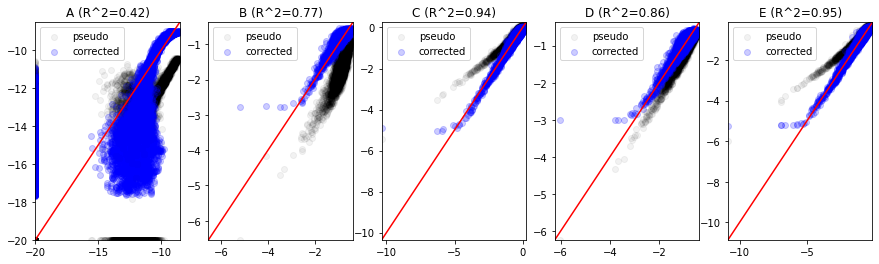

In [9]:

## Plot the results

def rnn_results_plot(ax, plot_number, fontsize=12, hide_labels=False):
    component = components[plot_number]
    y_measured = results[component]['measured']
    y_predicted = results[component]['corrected']
    y_pseudo = results[component]['pseudo']
    
    r_squared = results[component]['r^2']
    ax.scatter(y_measured, y_pseudo, alpha=0.05, marker='o', color='black', label=f'pseudo')
    ax.scatter(y_measured, y_predicted, alpha=0.2, marker='o', color='blue', label=f'corrected')
        
    y_combined = y_measured.tolist() + y_predicted.tolist() + y_pseudo
    y_min = np.min(y_combined)
    y_max = np.max(y_combined)
    plot_range = [y_min, y_max]
    ax.set_xlim(plot_range)
    ax.set_ylim(plot_range)
    ax.legend(loc='best')
    
    ax.plot(plot_range, plot_range, color='r')
    
    ax.set_title(f"{component} (R^2={r_squared:.2f})")
    

number_of_plots = len(results)

fig, axs = plt.subplots(1, number_of_plots, figsize=(15,4), constrained_layout=False)
for i in range(len(axs)):
    rnn_results_plot(axs[i], plot_number=i)

## Examine model performance

### Check one random case

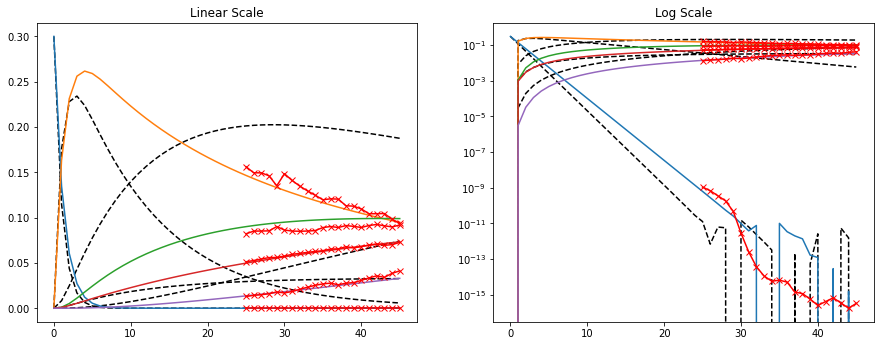

In [10]:
low_bound = [0, 0, 0, 0, 0]
high_bound = [1, 0.5, 0.5, 0.1, 0.1] if np.random.random() < 0.5 else [1, 0.0, 0.0, 0.0, 0.0]
initial_cc = np.random.uniform(low=low_bound, high=high_bound, size=len(components))

pseudo_profile = odeint(pseudo_rates, initial_cc, t, rtol=1e-10, atol=1e-10)
true_profile = odeint(true_rates, initial_cc, t, rtol=1e-10, atol=1e-10)
model_profile = []

for tend in t[tmin:].astype(int):
# for tend in range(len(t)):
    X_profile = pseudo_profile[:tend+1]
    X_profile = np.pad(X_profile, mode='constant',
                        pad_width=[(0, tmax-tend), (0, 0)], 
                        constant_values=masking_val)
    X_profile = np.reshape(X_profile, (-1, timesteps, features))
    
    model_profile_comp = []
    
    for i in range(len(components)):
        component = components[i]
        model = results[component]['model']
        ltu_model_comp_cc = (model.predict(ltu(X_profile)))[0][0]
        model_comp_cc = 10**ltu_model_comp_cc
        model_profile_comp.append(model_comp_cc)

    model_profile.append(model_profile_comp)

model_profile = np.reshape(model_profile, (-1, features))

fig, axs = plt.subplots(1, 2, figsize=(15,5.5), constrained_layout=False)

for k in range(len(axs)):
    axs[k].plot(t, pseudo_profile, label='pseudo', linestyle='dashed', color='black')
    axs[k].plot(t, true_profile, label='true')
    axs[k].plot(t[tmin:], model_profile, label='rnn model', marker = 'x', color='red')
    title = 'Linear Scale' if k==0 else 'Log Scale'
    axs[k].set_title(title)
    if k == len(axs)-1 : axs[k].set_yscale('log') 

### Gain statistical understanding

<AxesSubplot:title={'center':'relative error (200 random samples)'}>

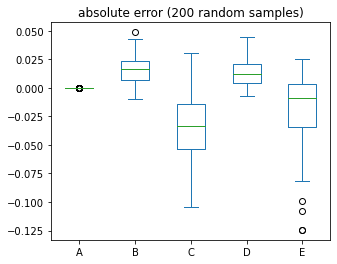

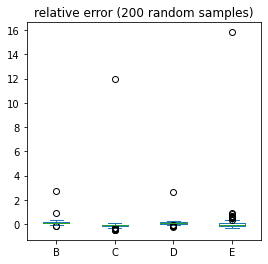

In [11]:
verification_sample_size = 200

error_abs = pd.DataFrame(columns=components)
error_rel = pd.DataFrame(columns=components)

for _ in range(verification_sample_size):

    # test new initial concentrations

    high_bound = [1, 0.5, 0.5, 0.1, 0.1] if np.random.random() < 0.5 else [1, 0.0, 0.0, 0.0, 0.0]

    cc_ini_sample = np.random.uniform(low=low_bound, high=high_bound, size=len(components))
    cc_ini_sample_with_error = [cc_ini_sample[i] * np.random.normal(loc=1, scale=err_initial) for i in range(len(cc_ini_sample))]

    # ode solves for concentration profile

    cc_model_pseudo_sample = odeint(pseudo_rates, cc_ini_sample_with_error, t)
    cc_model_true_sample = odeint(true_rates, cc_ini_sample, t)

    # ltu transformation of the pseudo concentration profile

    ltu_model_pseudo_sample = ltu(cc_model_pseudo_sample.flatten())
    ltu_model_pseudo_sample = np.reshape(ltu_model_pseudo_sample, (1, timesteps, features))

    # convert to dataframes

    cc_model_pseudo_sample_df = pd.DataFrame(cc_model_pseudo_sample, columns=components)
    cc_model_true_sample_df = pd.DataFrame(cc_model_true_sample, columns=components)

    error_each_run_abs = pd.DataFrame(0, index=np.arange(1), columns=components)
    error_each_run_rel = pd.DataFrame(0, index=np.arange(1), columns=components)

    # for col in [comp]:
    for i in range(len(components)):
        comp = components[i]    

        # rnn model to correct end concentration using pseudo concentration profile

        model = results[comp]['model']
        ltu_end_concentration_corrected = (model.predict(ltu_model_pseudo_sample))[0][0]
        end_concentration_corrected = 10**ltu_end_concentration_corrected
        end_concentration_corrected

        # calculate error in end concentrations

        end_concentration_true = cc_model_true_sample_df[comp].iloc[-1]
        error_each_run_abs[comp] = end_concentration_corrected - end_concentration_true
        error_each_run_rel[comp] = (end_concentration_corrected - end_concentration_true)/end_concentration_true

    error_abs = error_abs.append(error_each_run_abs, ignore_index=True)
    error_rel = error_rel.append(error_each_run_rel, ignore_index=True)

error_abs.plot.box(figsize=(5, 4), title=f'absolute error ({verification_sample_size} random samples)')
error_rel[components[1:]].plot.box(figsize=(4.2, 4), title=f'relative error ({verification_sample_size} random samples)')